# Helper Functions

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def collect_stock_history(ticker,period='1y',interval='1d'):

    stock = yf.Ticker(ticker)
    history = stock.history(period=period,interval=interval)

    return history

In [ ]:
def get_history():
    for i in range(len(portfolio)):
        portfolio[i]['history'] = collect_stock_history(portfolio[i]['ticker'],period='20y',interval='1d')

In [ ]:
def add_technical_indicators(df):
    # momentum
    df['MOM'] = df['Close'].diff(5)
    # RSI (14-day)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    # volume indicators
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    return df

# model features
def prepare_data(df):
    features = ['Open', 'High', 'Low', 'Close', 'Volume',
                'MOM', 'RSI', 'MA5', 'MA20',
                'Volume_MA5', 'Volume_MA20']
    df = add_technical_indicators(df)
    df = df.dropna()
    # normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[features])

    return df_scaled, scaler, features

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 3])  # 3 is close price index
    return np.array(X), np.array(y)


In [ ]:
def train_models():
  for i in range(len(portfolio)):
      print('Processing ',portfolio[i]['ticker'])
      df = portfolio[i]['history']
      df_scaled, scaler, features = prepare_data(df)
      seq_length = 50
      X, y = create_sequences(df_scaled, seq_length)
      train_size = int(len(X) * 0.8)
      X_train, y_train = X[:train_size], y[:train_size]
      X_test, y_test = X[train_size:], y[train_size:]

      portfolio[i]['X_train'] = X_train
      portfolio[i]['y_train'] = y_train
      portfolio[i]['X_test'] = X_test
      portfolio[i]['y_test'] = y_test

      model = Sequential([
          LSTM(100, return_sequences=True, input_shape=(seq_length, len(features))),
          Dropout(0.2),
          LSTM(100, return_sequences=True),
          Dropout(0.2),
          LSTM(50, return_sequences=False),
          Dropout(0.2),
          Dense(25),
          Dense(1)
      ])

      initial_learning_rate = 0.001
      decay_steps = 10000
      decay_rate = 0.9
      learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate, decay_steps, decay_rate
      )
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
      model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=10,
          restore_best_weights=True
      )
      history = model.fit(
          X_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping]
      )
      portfolio[i]['model'] = model
      portfolio[i]['scaler'] = scaler
      portfolio[i]['features'] = features

In [ ]:
def predict_prices():
    for i in range(len(portfolio)):
        model = portfolio[i]['model']
        scaler = portfolio[i]['scaler']
        features = portfolio[i]['features']

        X_test = portfolio[i]['X_test']
        y_test = portfolio[i]['y_test']

        print(len(y_test))

        predictions = model.predict(X_test)

        # create template array filled with zeros and put pred vals in the close price column (idx 3)
        pred_template = np.zeros((len(predictions), len(features)))
        pred_template[:, 3] = predictions.flatten()

        # convert preds back to original scale
        predictions = scaler.inverse_transform(pred_template)[:, 3]

        # actual values transformation
        actual_template = np.zeros((len(y_test), len(features)))
        actual_template[:, 3] = y_test
        actual_prices = scaler.inverse_transform(actual_template)[:, 3]

        plt.figure(figsize=(12,6))
        plt.plot(actual_prices, label="Actual Prices", color="blue")
        plt.plot(predictions, label="Predicted Prices", color="red")
        plt.title(f"Stock Price Prediction for {portfolio[i]['ticker']}")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

        mae = mean_absolute_error(actual_prices, predictions)
        rmse = np.sqrt(mean_squared_error(actual_prices, predictions))

        print(f"Mean Absolute Error (MAE) in dollars per prediction: {mae:.4f}")
        print(f"Root Mean Squared Error (RMSE) in dollars per prediction: {rmse:.4f}")

        portfolio[i]['predictions'] = predictions
        portfolio[i]['actual_prices'] = actual_prices


# Trading

In [ ]:
portfolio = [{'ticker':'AAPL'},
              {'ticker':'NVDA'},
             {'ticker':'COKE'}]

Processing  AAPL


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0053 - mae: 0.0437 - val_loss: 0.0012 - val_mae: 0.0277
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.0487e-04 - mae: 0.0116 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.5520e-04 - mae: 0.0108 - val_loss: 0.0017 - val_mae: 0.0316
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.3351e-04 - mae: 0.0097 - val_loss: 9.5064e-04 - val_mae: 0.0241
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.4983e-04 - mae: 0.0104 - val_loss: 8.9907e-04 - val_mae: 0.0246
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.1766e-04 - mae: 0.0097 - val_loss: 0.0025 - val_mae: 0.0435
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6344e-04 - mae: 0.0102 - val_loss: 0.0103 - val_mae: 0.0925
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.6053e-04 - mae: 0.0102 - val_loss: 0.0021 - val_mae: 0.0386
Epoch 9/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0017 - mae: 0.0250 - val_loss: 0.0123 - val_mae: 0.0632
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.4855e-05 - mae: 0.0045 - val_loss: 0.0115 - val_mae: 0.0598
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8669e-05 - mae: 0.0040 - val_loss: 0.0141 - val_mae: 0.0667
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.9711e-05 - mae: 0.0033 - val_loss: 0.0120 - val_mae: 0.0602
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7891e-05 - mae: 0.0032 - val_loss: 0.0147 - val_mae: 0.0674
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.5050e-05 - mae: 0.0028 - val_loss: 0.0125 - val_mae: 0.0610
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.7363e-05 - mae: 0.0031 - val_loss: 0.0139 - val_mae: 0.0651
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.2578e-05 - mae: 0.0026 - val_loss: 0.0151 - val_mae: 0.0685
Epoch 9/50
125/125 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0021 - mae: 0.0289 - val_loss: 0.0070 - val_mae: 0.0549
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.1551e-04 - mae: 0.0074 - val_loss: 0.0062 - val_mae: 0.0490
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1984e-04 - mae: 0.0073 - val_loss: 0.0081 - val_mae: 0.0575
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 8.7721e-05 - mae: 0.0066 - val_loss: 0.0073 - val_mae: 0.0562
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.2767e-04 - mae: 0.0083 - val_loss: 0.0092 - val_mae: 0.0688
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.7287e-05 - mae: 0.0060 - val_loss: 0.0062 - val_mae: 0.0514
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.2955e-05 - mae: 0.0065 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.6641e-05 - mae: 0.0062 - val_loss: 0.0065 - val_mae: 0.0550
Epoch 9/50
125/125 ━━━━━━━━━━━━

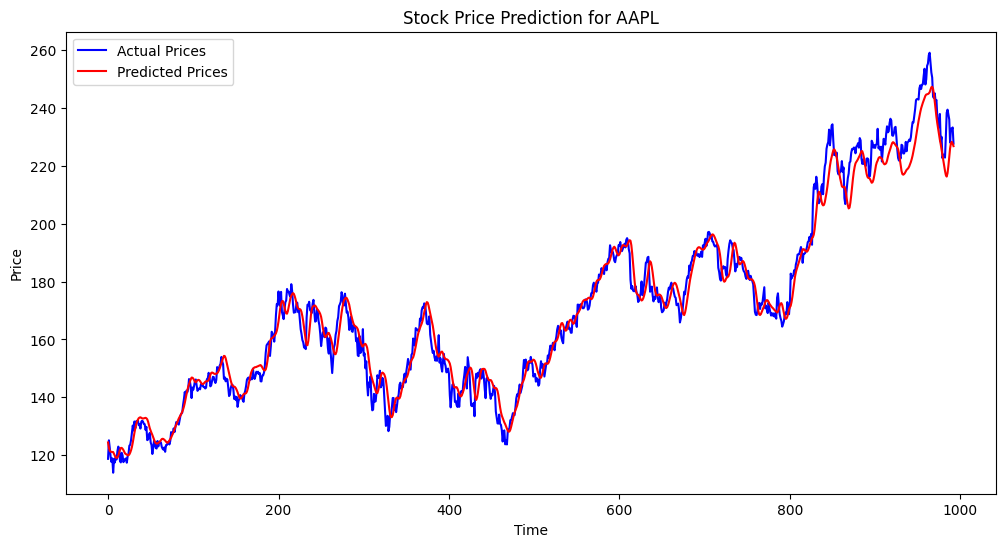

Mean Absolute Error (MAE) in dollars per prediction: 3.9876
Root Mean Squared Error (RMSE) in dollars per prediction: 5.2514
993
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


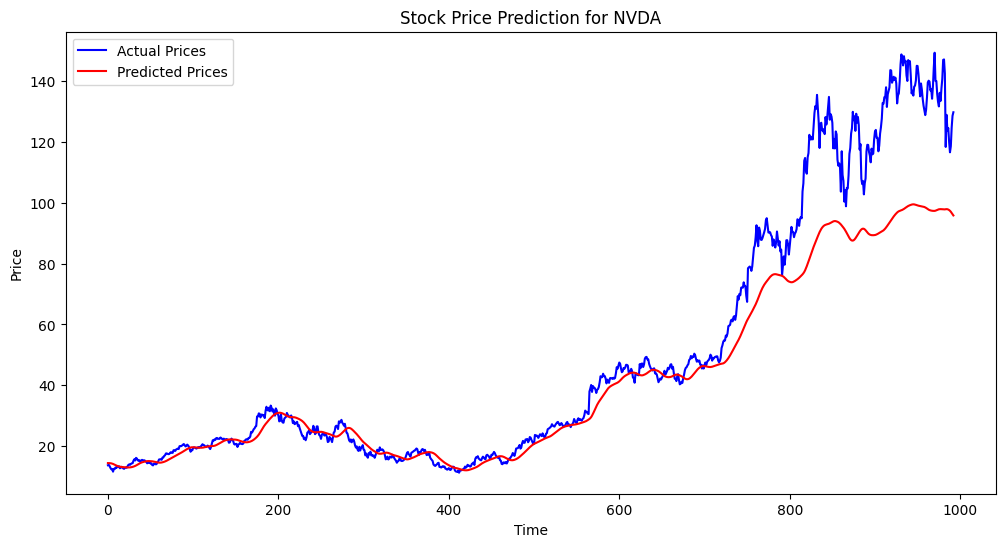

Mean Absolute Error (MAE) in dollars per prediction: 8.9349
Root Mean Squared Error (RMSE) in dollars per prediction: 16.0336
993
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


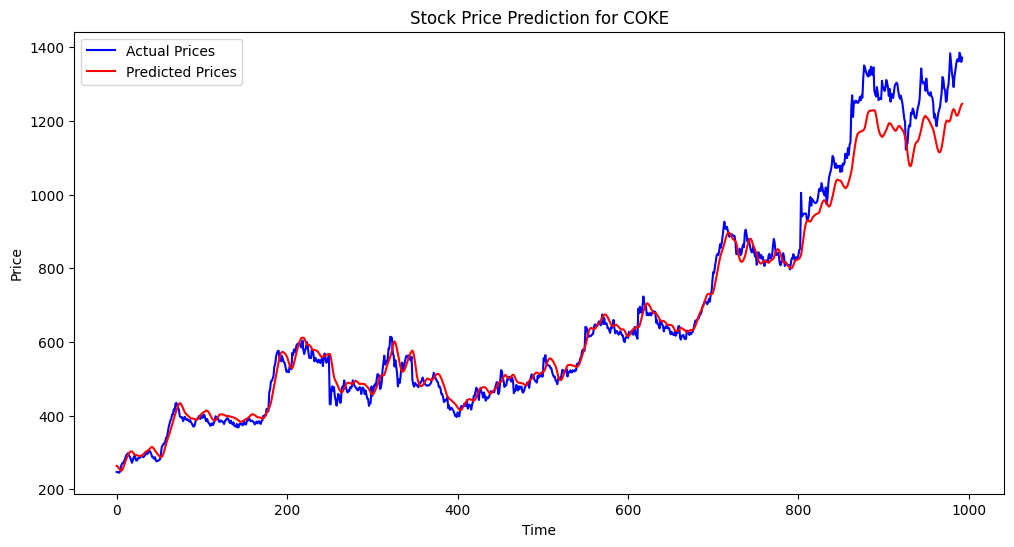

Mean Absolute Error (MAE) in dollars per prediction: 31.2401
Root Mean Squared Error (RMSE) in dollars per prediction: 46.8794


In [ ]:
get_history()
train_models()
predict_prices()

In [ ]:
# portfolio parameters
total_cash = 10000
threshold = 0.005
min_profit = 0.001

In [ ]:
# mock trading simulation
portfolio_value = 0
shares_held = {stock['ticker']: 0 for stock in portfolio}
transactions = []
portfolio_value_history = []
cash = total_cash
for i in range(min([len(stock['actual_prices']) for stock in portfolio]) - 1):
    print(f"\n--- Day {i} ---")

    # update portfolio value before trading
    portfolio_value = cash
    for stock in portfolio:
        ticker = stock['ticker']
        current_price = stock['actual_prices'][i]
        portfolio_value += shares_held[ticker] * current_price

    portfolio_value_history.append(portfolio_value)

    for stock in portfolio:
        ticker = stock['ticker']
        actual_prices = stock['actual_prices']
        predicted_prices = stock['predictions']

        current_price = actual_prices[i]
        predicted_next_price = predicted_prices[i+1]

        print(f"\n{ticker}: Current Price: {current_price:.2f}, Predicted Next: {predicted_next_price:.2f}")
        print(f"    Shares Held: {shares_held[ticker]}, Cash Available: {cash:.2f}")

        # BUY condition: predicted price increase
        if (predicted_next_price > current_price * (1 + threshold) and cash >= current_price):
            shares_to_buy = int((cash * 0.8) // current_price)
            if shares_to_buy > 0:
                cash -= shares_to_buy * current_price
                shares_held[ticker] += shares_to_buy
                transactions.append(f"BUY {shares_to_buy} shares of {ticker} at {current_price:.2f}")
                print(f"BUY {shares_to_buy} shares of {ticker} at {current_price:.2f}")

        # SELL condition: predicted price drop and profit > min_profit
        elif (predicted_next_price < current_price * (1 - threshold) and
              (current_price - predicted_next_price) / current_price > min_profit and shares_held[ticker] > 0):
            shares_to_sell = shares_held[ticker]
            cash += shares_to_sell * current_price
            shares_held[ticker] -= shares_to_sell
            transactions.append(f"SELL {shares_to_sell} shares of {ticker} at {current_price:.2f}")
            print(f"SELL {shares_to_sell} shares of {ticker} at {current_price:.2f}")

# get final portfolio value
final_portfolio_value = cash
for stock in portfolio:
    ticker = stock['ticker']
    final_price = stock['actual_prices'][-1]
    final_portfolio_value += shares_held[ticker] * final_price

print("\n--- Final Trade Summary ---")
print(f"Initial Investment: ${total_cash:,.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Total Return: {((final_portfolio_value - total_cash) / total_cash) * 100:.2f}%")

daily_returns = np.diff(portfolio_value_history) / portfolio_value_history[:-1]
annualized_return = np.mean(daily_returns) * 252
print(f"\nAnnualized Return: {annualized_return:.2%}")
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Total Trades Executed: {len(transactions)}")


Streaming output truncated to the last 5000 lines.
--- Day 553 ---

AAPL: Current Price: 170.24, Predicted Next: 170.54
    Shares Held: 0, Cash Available: 14124.98

NVDA: Current Price: 28.56, Predicted Next: 27.49
    Shares Held: 0, Cash Available: 14124.98

COKE: Current Price: 613.85, Predicted Next: 629.62
    Shares Held: 0, Cash Available: 14124.98
    ✅ BUY 18 shares of COKE at 613.85

--- Day 554 ---

AAPL: Current Price: 172.02, Predicted Next: 171.31
    Shares Held: 0, Cash Available: 3075.63

NVDA: Current Price: 28.87, Predicted Next: 27.58
    Shares Held: 0, Cash Available: 3075.63

COKE: Current Price: 614.03, Predicted Next: 635.09
    Shares Held: 18, Cash Available: 3075.63
    ✅ BUY 4 shares of COKE at 614.03

--- Day 555 ---

AAPL: Current Price: 172.20, Predicted Next: 172.34
    Shares Held: 0, Cash Available: 619.51

NVDA: Current Price: 28.56, Predicted Next: 27.68
    Shares Held: 0, Cash Available: 619.51

COKE: Current Price: 617.25, Predicted Next: 637.69

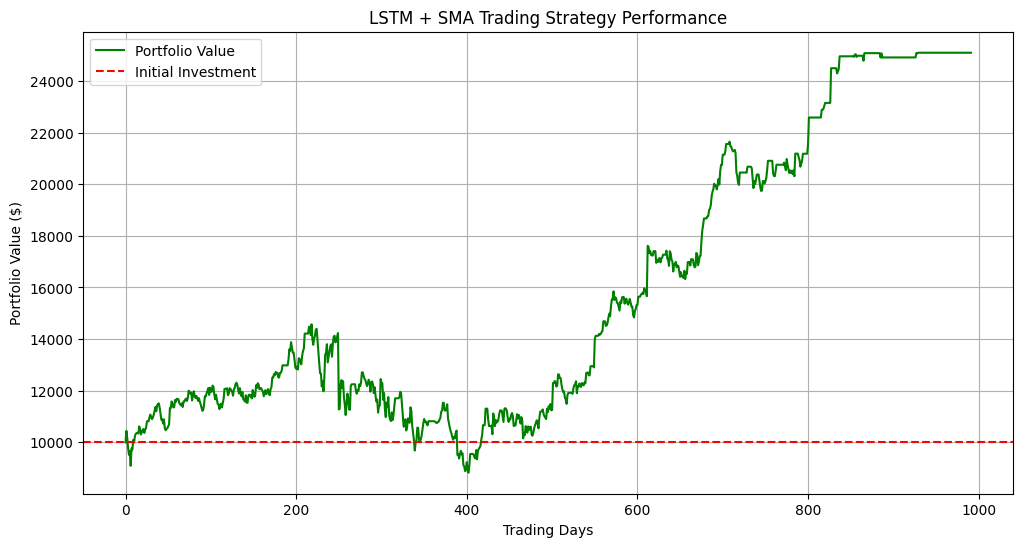

In [ ]:
#Mock Trading Results Plot
plt.figure(figsize=(12,6))
plt.plot(portfolio_value_history, label="Portfolio Value", color="green")
plt.axhline(y=total_cash, color='r', linestyle='--', label='Initial Investment')
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")
plt.title("LSTM + SMA Trading Strategy Performance")
plt.legend()
plt.grid(True)
plt.show()
